In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d  
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import random
from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# from EDA_helper import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import torch.nn.functional as F
from torch.autograd import Variable

!pip install coral_pytorch
import coral_pytorch as coral
from coral_pytorch.layers import CoralLayer
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.losses import coral_loss
from coral_pytorch.dataset import proba_to_label


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Google Colab Instructions:



1.   Create folder "Honors Thesis"
2.   Add Neural_nets_cuda.ipynb to folder
3.   Create subfolder "datasets" containing the contents of the datasets folder from GitHub



In [ ]:
from google.colab import drive
drive.mount('/drive')

Run the following cell to define data processing funcs

In [2]:
#@title
def format_df(figs, ratings, to_drop = []):
    """
    figs: Pandas df, features
    ratings: Pandas df, labels
    to_drop: list, cols to remove

    """

#     print(len(ratings["Ticker Symbol"].unique()))
    ratings1 = ratings[ratings['S&P Domestic Long Term Issuer Credit Rating'].notna()]
    ratings1 = ratings1[['Global Company Key','S&P Domestic Long Term Issuer Credit Rating', 'Data Date',
                        'Ticker Symbol']]

    print("Unique Companies in Ratings: ", len(ratings1["Ticker Symbol"].unique()))
    # print("Unique Companies in Features: ", len(figs["Ticker Symbol"].unique()))

    ## WE DON'T USE THIS
    if len(to_drop) == 0:
        figs_1 = figs.drop(list(figs.columns[[2, 3,4,11,12, 14, 16, 18, 20, 21, 23, 26, 30, 33, 35, 36, 37, 38]]), axis=1).dropna()
    else:
        # print(ratings1.shape, figs.shape)
        figs_1 = figs.drop(to_drop, axis=1).dropna()
        # print(ratings1.shape, figs_1.shape)
    print("Unique Companies in Features: ", len(figs_1["Ticker Symbol"].unique()))

    # lst3 = [value for value in ratings1["Ticker Symbol"].unique() if value in figs_1["Ticker Symbol"].unique()]


    companies = ratings1["Ticker Symbol"].unique()
    # companies
    # quarts = ['1231', '0331', '0630', '0930']
    # figs_1 = figs_1.loc[figs_1['Ticker Symbol'].isin(companies)]
    print("changed")
    figs_1['Data Date'] = figs_1['Data Date'].astype(str)
    ratings1['Data Date'] = ratings1['Data Date'].astype(str)
    # ratings1 = ratings1.loc[ratings1['Data Date'].str[-4:].isin(quarts)]
    return figs_1, ratings1


def join_numerical(figs_1, ratings1, numerical=[], ind_to_keep=[], years=[]):
    """
    in
    figs_1: Pandas df, features
    ratings1: Pandas df, labels
    numerical: List of str col. names of numerical columns to keep

    out
    x: np array
    y: np array
    merged: Pandas df
    """
    merged = pd.merge(figs_1, ratings1, how='inner', on=["Data Date", "Ticker Symbol"])
    merged = merged.rename(columns = {'S&P Domestic Long Term Issuer Credit Rating':'rating'})

    if len(numerical) == 0:
        numerical = ['Current Assets - Total', 'Cash','Long-Term Debt - Total',
        'Earnings Per Share (Basic) - Including Extraordinary Items - 12 Months Moving',
        'Invested Capital - Total - Quarterly','Inventories - Total', 'Pretax Income',
        'Operating Income Before Depreciation']
    vals = merged['Data Date'].str[:4]
    merged['year'] = vals
    # yrs =



    merged = merged[(merged['rating'] != 'D') & (merged['rating'] != 'SD')]

    counts =  merged['rating'].value_counts()
    good_classes = [counts.index[j] for j in range(len(counts)) if counts[j] >=7]
    merged = merged[merged['rating'].isin(good_classes)]
    if len(years) != 0:
        merged = merged[merged['year'].isin(years)]
    # merged = merged.drop(['year'], axis=1)
    if len(ind_to_keep) == 0:
        ind_to_keep = [True]*len(merged)

    x = merged.loc[ind_to_keep, numerical].values
    y = merged.loc[ind_to_keep,['rating']].values
    full = numerical.copy()
    full.append('rating')
    full.append('year')
    full.append('Ticker Symbol')



    merged = merged.loc[ind_to_keep, full]


    print("Intersection of Companies: ", len(merged['Ticker Symbol'].unique()))
    return x, y, merged

def encode(Y, form='', custom={}):

    if custom:
        pass

    else:
        if form == 'full':
            embed = {'BBB-':-1, 'BBB':0, 'A-':2, 'BBB+':1, 'AA+':7, 'AA':6, 'A':3, 'AA-':5, 'BB':-3, 'BB+':-2,
                                'AAA':8, 'B':-6, 'B+':-5, 'A+':4, 'BB-':-4, 'CCC+':-8,'CCC':-9,'CCC-':-10, 'CC+':-11,'CC':-12,
                                'CC-':-13,'B-':-7}
            labels = ['CCC','CCC+','B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+',
                   'AA-', 'AA', 'AA+', 'AAA']
        elif form == 'stanfurd':
            embed = {'BBB-':-1, 'BBB':0, 'A-':2, 'BBB+':1, 'AA+':7, 'AA':6, 'A':3, 'AA-':5, 'BB':-3, 'BB+':-2,
                                'AAA':7, 'B':-6, 'B+':-5, 'A+':4, 'BB-':-4, 'CCC+':-8, 'B-':-7}
            labels = ['CCC+','B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+',
                   'AA-', 'AA', 'AA+', 'AAA']
        elif form == 'three':
            embed = {'BBB-':1, 'BBB':1, 'A-':2, 'BBB+':1, 'AA+':2, 'AA':2, 'A':2, 'AA-':2, 'BB':0, 'BB+':0,
                    'AAA':2, 'B':0, 'B+':0, 'A+':2, 'BB-':0, 'CCC+':0, 'B-':0}
            labels = ['low', 'med', 'high']
        elif form == "IG":
            embed = {'BBB-':1, 'BBB':1, 'A-':1, 'BBB+':1, 'AA+':1, 'AA':1, 'A':1, 'AA-':1, 'BB':0, 'BB+':0,
                    'AAA':1, 'B':0, 'B+':0, 'A+':1, 'BB-':0, 'CCC+':0, 'B-':0}
            labels = ['HY', 'IG']

        elif form == 'letters':
            embed = {'BBB-':3, 'BBB':3, 'A-':4, 'BBB+':3, 'AA+':5, 'AA':5, 'A':4, 'AA-':5, 'BB':2, 'BB+':2,
                    'AAA':6, 'B':1, 'B+':1, 'A+':4, 'BB-':2, 'CCC+':0, 'B-':1}
            labels = ['CCC', 'B', 'BB', 'BBB', 'A', 'AA','AAA']
        # elif form == 'letters ex CCC':
        else:
            embed = {'BBB-':4, 'BBB':4, 'A-':5, 'BBB+':4, 'AA+':6, 'AA':6, 'A':5, 'AA-':6, 'BB':3, 'BB+':3,
                  'AAA':7, 'B':2, 'B+':2, 'A+':5, 'BB-':3, 'CCC+':1, 'B-':2, 'CCC':1,'CCC-':1, 'CC+':0,'CC':0,
                    'CC-':0}
            labels = ['B', 'BB', 'BBB', 'A', 'AA','AAA']
            # colors = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139', '#828282', '#17d8ff', '#1770ff']
        Y_emb = np.array([embed[i] for i in Y.T[0]]).ravel()

    return Y_emb, labels

def decode(Y, form='', custom={}):
    if form == 'full':
            embed = {-1:'BBB-', 0:'BBB', 2:'A-', 1:'BBB+', 7:'AA+', 6:'AA', 3:'A', 5:'AA-', -3:'BB', -2:'BB+',
                            8:'AAA', -6:'B', -5:'B+', 4:'A+', -4:'BB-', -8:'CCC+',-9:'CCC',-10:'CCC-', -11:'CC+',
                     -12:'CC', -13:'CC-',-7:'B-'}
            labels = ['CC','CC+','CCC', 'CCC+','B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+',
                   'AA-', 'AA', 'AA+', 'AAA']
    Y_emb = np.array([embed[i] for i in Y.T[0]]).ravel()
    return Y_emb, labels
def data_split(X, Y,full=None, split=[0.7, 0.1], method="numer", smote=False, seed=100, neigh=5):
    """
    split = [ratio of train, ratio of val]
    note: ratio of test = 1.0 - (ratio of train + ratio of val)
    """
    np.random.seed(seed)

    #### TODO: if smote, give a non-smote Validation set
    ## No Validation set
    if split[1] == 0.0:
        test_split = 1.0 - split[0]

        if method == 'numer':
            splits = int(np.round(split[0]*X.shape[0]))
            cc = list(np.arange(X.shape[0])).copy()
            np.random.shuffle(cc)
            train_inds = cc[:splits]
            test_inds = cc[splits:]
            X_train = X[train_inds, :]
            Y_train = Y[train_inds]
            X_test =  X[test_inds, :]
            Y_test =  Y[test_inds]

            X_val = []
            Y_val = []

        # elif method == "holdout":
            # X is DataFrame
            # Y is empty
        if smote:
            # ks = np.min([np.min(), 5])
            dd = {}
            uu = {}
            kounts = pd.Series(enc_Y).value_counts().to_dict()
            max_val = max(kounts.values())
            for k,v in kounts.items():
              dd[k] = int((max_val - v)*0.2 + v)
            for c,d in sorted(kounts.items(), key=lambda item: item[1])[-5:]:
              uu[c] = int(d*0.7)

            oversample = SMOTE(sampling_strategy=dd, k_neighbors=neigh)
            undersample =RandomUnderSampler(sampling_strategy=uu)
            steps = [('o', oversample), ('u', undersample)]
            pipeline = Pipeline(steps=steps)
            # print("SVMMMM")

            X_train, Y_train = pipeline.fit_resample(X_train, Y_train)


    else:
        if method == 'numer':
            splits = int(np.round(split[0]*X.shape[0]))
            splits1 = splits + int(np.round(split[1]*X.shape[0]))
            cc = list(np.arange(X.shape[0])).copy()
            np.random.shuffle(cc)
            train_inds = cc[:splits]
            val_inds = cc[splits:splits1]
            test_inds = cc[splits1:]

            X_train = X[train_inds, :]
            Y_train = Y[train_inds]
            X_val = X[val_inds, :]
            Y_val = Y[val_inds]

            X_test =  X[test_inds, :]
            Y_test =  Y[test_inds]

        if smote:
            # ks = np.min([np.min(), 5])
            oversample = SMOTE(k_neighbors=neigh)
            X_train, Y_train = oversample.fit_resample(X_train, Y_train)



    return X_train, Y_train, X_val, Y_val, X_test, Y_test


In [3]:
def import_data():
  ratings = pd.read_excel("drive/My Drive/Honors Thesis/datasets/ratings_all_energ_new.xlsx")
  ratio = pd.read_excel("drive/My Drive/Honors Thesis/datasets/ratios_2_all_energ_new.xlsx")
  energ = pd.read_excel("drive/My Drive/Honors Thesis/datasets/energ_specific_all_new.xlsx")
  # # ratings = pd.read_excel("../datasets/ratings_2_06-17.xlsx")
  # # ratio = pd.read_excel("../datasets/ratio_figs_2.xlsx")
  cols = ratio.columns
  ratio = ratio.drop(cols[0], axis=1)
  ratio = ratio.rename(columns = {'Public Date':'Data Date','EXCHANGE TICKER SYMBOL - HISTORICAL':'Ticker Symbol'})

  ratio1, ratings1 = format_df(ratio.copy(), ratings.copy(), 
                              ['Trailing P/E to Growth (PEG) ratio','Dividend Yield', 
                                'Interest/Average Total Debt', 'Free Cash Flow/Operating Cash Flow'])

  numer = list(ratio1.columns[4:-1])

  cols = energ.columns
  # aa = cols[[0,1,2,3,4,5,6, 18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
  aa = cols[[0,1,2,3,4,5,6, 10,11,14,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
  energ1 = energ.drop(
        aa, 
      axis=1)
  # energ1 = energ_.fillna(energ_.mean()) 
  # energ1, _ = format_df(energ.copy(), ratings.copy(), 
  #                             aa)
  energ1['Data Date'] = energ1['Data Date'].astype(str)

  features = pd.merge(ratio1, energ1,how='left',on=["Data Date", "Ticker Symbol"])
  # len(features["Ticker Symbol"].unique())
  lst3 = [value for value in ratio["Ticker Symbol"].unique() if value in energ["Ticker Symbol"].unique()]
  # ratio1["Ticker Symbol"].unique()
  # len(lst3)
  print(len(ratio["Ticker Symbol"].unique()), len(energ["Ticker Symbol"].unique()), 
        len(ratio1["Ticker Symbol"].unique()), len(energ1["Ticker Symbol"].unique()))

  first_col = features.pop("Ticker Symbol") 
  ff = len(features.columns)
  features.insert(ff, "Ticker Symbol", first_col)
  numer = list(features.columns[4:-1])

  X1,Y1,full1 = join_numerical(features, ratings1, numerical=numer)
  return X1,Y1,full1

In [4]:
def plotGD(losses, model):
  plt.plot(losses)
  plt.ylabel('Loss')
  plt.xlabel('Iterations (in 100s)')
  plt.title(model + " Gradient Descent (ADAM)")
def plotAcc(vals, model):
  plt.plot(vals)
  plt.ylabel('Accuracy')
  plt.xlabel('Iterations (in 100s)')
  plt.title(model +  " Gradient Descent (ADAM)")

# Process Data

In [5]:
X1,Y1,full1 = import_data()

X1, X_test_,Y1, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=100)

ss = StandardScaler()
scl_X = ss.fit_transform(X1)
scl_X = np.nan_to_num(scl_X)
enc_Y, _ = encode(Y1, 'full') 

n_classes = len(np.unique(enc_Y))
n_feats = scl_X.shape[1]

X_test = ss.transform(X_test_)
X_test = np.nan_to_num(X_test)

Y_test, _ = encode(Y_test, 'full')
minny = np.min((np.min(enc_Y), np.min(Y_test)))

enc_Y += np.abs(minny)
Y_test += np.abs(minny)


Unique Companies in Ratings:  335
Unique Companies in Features:  253
changed
273 819 253 819
Intersection of Companies:  97


In [6]:
len(np.unique(enc_Y))
num_classes = n_classes

In [7]:
X_train, Y_train, _, _,X_val, Y_val = data_split(scl_X, enc_Y, split=[0.8, 0.0], smote=False, seed = 100, neigh=4)

In [9]:
Xt_train = torch.FloatTensor(X_train)
Yt_train = torch.Tensor(Y_train)
Xt_val = torch.FloatTensor(X_val)
Yt_val = torch.Tensor(Y_val)

Xt_test = torch.FloatTensor(X_test)
Yt_test = torch.Tensor(Y_test)

train_set = TensorDataset(Xt_train, Yt_train)
loader_train = DataLoader(train_set, batch_size=10)

val_set = TensorDataset(Xt_val, Yt_val)
loader_val = DataLoader(val_set, batch_size=10)

test_set = TensorDataset(Xt_test, Yt_test)
loader_test = DataLoader(test_set, batch_size=10)



In [10]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [11]:
def validate(loader, model, mode = 0):
    num_correct = 0
    num_samples = 0
    last_corr = 0
    last_samples = 0
    mae = 0.
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
 
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.float().to(device=device)

            if mode == 1:
              scores = model(x)
              _, preds = scores.max(1)
            elif mode == 2:
              scores = model(x)
              _, preds = scores.max(1)
              y = torch.squeeze(y)
            elif mode == 3:
              scores, probs = model(x)
              # _, preds = scores.max(1)
              preds = proba_to_label(probs).float()
              # y = torch.squeeze(y)
              y = torch.flatten(y.view(y.size(0), -1).int())


            else:
              scores, probs = model(x)
            # print("scores: ",scores.size())
              preds = proba_to_label(probs).float()

            # print('preds: ', preds.size(), 'y: ',y.size())
            num_correct += (preds == y).sum()
            # if y[:, -1] != y[:, -1]: 

            if mode == 2:
              num_samples += preds.size(0) * preds.size(1)
              # last_corr += (preds[:, -1] == y[:, -1]).sum()
              # last_samples += preds.size(0)            

            else:
              num_samples += preds.size(0)
            mae += torch.sum(torch.abs(preds - y))
            # mse += torch.sum((preds - y)**2)
        acc = float(num_correct) / num_samples
        # if mode ==2:
        #   last_acc = float(last_corr) / last_samples
        #   print(last_acc)
        mae = mae / num_samples
        # mse = mse / num_examples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc), f'Mean absolute error: {mae:.2f}')
    return acc, mae

# Train Func.


In [12]:
def train_func(model, optimizer, epochs=1, mode=0):
    """
    Inputs:
    - model: A PyTorch model.
    - optimizer: Optimizer object
    - epochs: int  
    Returns: Lists of validation accuracies at the end of each epoch.
    """
    print(device)
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    train_accs = []
    val_accs = []
    val_mae = []
    losses = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            # print(y)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU

            if mode == 1:
              y = y.to(device=device, dtype=torch.long)
              scores = model(x)
              
              loss = F.cross_entropy(scores, y)
            # LSTM  
            elif mode == 2:
              ## LSTM Mode
              y = y.to(device=device, dtype=torch.long)
              y = torch.squeeze(y)
              scores = model(x)

              # print(scores.size(), y.size())
              loss = F.cross_entropy(scores, y)
            # OR-LSTM
            elif mode == 3:
              # print(torch.flatten(y.view(y.size(0), -1).int()).size())
              # print("nums :", num_classes)
              levels = levels_from_labelbatch(torch.flatten(y.view(y.size(0), -1).int()), num_classes=num_classes + 1)
              # print('lev: ', levels.size())
              levels = levels.to(device=device, dtype=torch.long)
              # print("levels: ",levels.size())
              scores, probs = model(x)
              # print('s:',scores.size(), 'lev: ', levels.size())
              loss = coral_loss(scores, levels)

            # CORAL
            else:
              levels = levels_from_labelbatch(y.int(), num_classes=num_classes)
              levels = levels.to(device=device, dtype=torch.long)
              scores, probs = model(x)
              loss = coral_loss(scores, levels)    

            # print(scores)
            # print(scores.size(), y.size())
            # loss = F.nll_loss(scores, y, reduction='sum')
            # loss = OrdinalEntropyLoss(scores, y)

            # print(loss.size())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                losses.append(loss.item())
                validate(loader_val, model, mode)
                print()
        acc_, mae_ = validate(loader_val, model, mode)
        val_accs.append(acc_)
        val_mae.append(mae_)
        
    return val_accs, val_mae, losses

# CORAL NN

In [13]:
class CoralNet(nn.Module):
  def __init__(self, num_classes, num_features,                              
                                    hidden_layer_size = 100 ):
    super().__init__()

    self.features = torch.nn.Sequential(
        nn.Linear(num_features, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),

        )

    self.fc = CoralLayer(hidden_layer_size, num_classes)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    logits =  self.fc(x)
    probas = torch.sigmoid(logits)

    return logits, probas


# Baseline Fully Connected Neural Network

In [14]:
class NormalNet(nn.Module):
  def __init__(self, num_classes, num_features,                              
                                    hidden_layer_size = 100 ):
    super().__init__()

    self.features = torch.nn.Sequential(
        nn.Linear(num_features, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, hidden_layer_size),
        nn.ReLU()
        )
    self.fc = nn.Linear(hidden_layer_size, num_classes)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    logits =  self.fc(x)


    return logits



In [15]:
num_features = n_feats
learning_rate = 7e-4
hidden_layer_size = 250 
epics = 100

num_classes = n_classes

# CORAL NN: Train

In [16]:
model1 = None
optimizer1 = None

model1 = CoralNet(num_classes, num_features, hidden_layer_size)
normal = 0

# optimizer1 = optim.SGD(model1.parameters(), lr=learning_rate,
                    #  momentum=0.9, nesterov=True)  
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)  

coral_validation_accs, coral_maes, coral_losses = train_func(model1, optimizer1, epochs=epics, mode=normal)
print("Final Acc: \n")
validate(loader_val, model1, normal)

cuda
Iteration 0, loss = 11.5596
Got 18 / 1275 correct (1.41) Mean absolute error: 10.03

Iteration 100, loss = 9.0661
Got 103 / 1275 correct (8.08) Mean absolute error: 3.41

Iteration 200, loss = 8.0182
Got 88 / 1275 correct (6.90) Mean absolute error: 3.76

Iteration 300, loss = 8.2787
Got 154 / 1275 correct (12.08) Mean absolute error: 2.71

Iteration 400, loss = 8.4018
Got 166 / 1275 correct (13.02) Mean absolute error: 2.59

Iteration 500, loss = 7.4868
Got 150 / 1275 correct (11.76) Mean absolute error: 2.65

Got 92 / 1275 correct (7.22) Mean absolute error: 3.37
Iteration 0, loss = 7.8532
Got 104 / 1275 correct (8.16) Mean absolute error: 3.16

Iteration 100, loss = 7.6507
Got 169 / 1275 correct (13.25) Mean absolute error: 2.19

Iteration 200, loss = 6.1754
Got 195 / 1275 correct (15.29) Mean absolute error: 2.17

Iteration 300, loss = 6.9071
Got 238 / 1275 correct (18.67) Mean absolute error: 1.89

Iteration 400, loss = 6.9043
Got 243 / 1275 correct (19.06) Mean absolute erro

(0.8454901960784313, tensor(0.2078, device='cuda:0'))

# CORAL NN: Test

In [17]:
validate(loader_test, model1, normal)

Got 1366 / 1594 correct (85.70) Mean absolute error: 0.20


(0.8569636135508155, tensor(0.2020, device='cuda:0'))

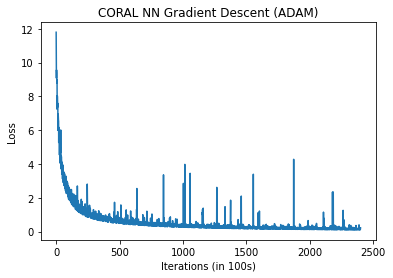

In [ ]:
plotGD(coral_losses, model='CORAL NN')


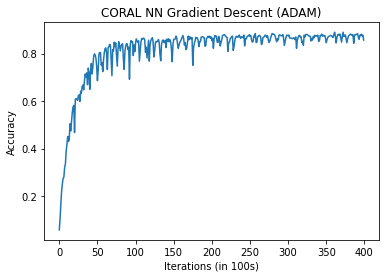

In [ ]:
plotAcc(coral_validation_accs, model='CORAL NN')

# Baseline NN: Train

In [18]:

model = NormalNet(num_classes, num_features, hidden_layer_size)
normal = 1
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

validation_accs, maes, losses = train_func(model, optimizer, epochs=100, mode=normal)
print("Final Acc: \n")
validate(loader_val, model, normal)
# plt.plot(losses)

cuda
Iteration 0, loss = 2.8932
Got 3 / 1275 correct (0.24) Mean absolute error: 7.13

Iteration 100, loss = 2.2719
Got 201 / 1275 correct (15.76) Mean absolute error: 2.89

Iteration 200, loss = 2.2390
Got 339 / 1275 correct (26.59) Mean absolute error: 2.01

Iteration 300, loss = 1.7386
Got 355 / 1275 correct (27.84) Mean absolute error: 1.96

Iteration 400, loss = 1.4415
Got 387 / 1275 correct (30.35) Mean absolute error: 1.71

Iteration 500, loss = 2.1291
Got 413 / 1275 correct (32.39) Mean absolute error: 1.76

Got 431 / 1275 correct (33.80) Mean absolute error: 1.67
Iteration 0, loss = 2.2740
Got 424 / 1275 correct (33.25) Mean absolute error: 1.68

Iteration 100, loss = 2.1589
Got 418 / 1275 correct (32.78) Mean absolute error: 1.71

Iteration 200, loss = 1.0864
Got 488 / 1275 correct (38.27) Mean absolute error: 1.56

Iteration 300, loss = 1.0885
Got 523 / 1275 correct (41.02) Mean absolute error: 1.47

Iteration 400, loss = 0.8822
Got 520 / 1275 correct (40.78) Mean absolute e

(0.8941176470588236, tensor(0.2212, device='cuda:0'))

# Baseline NN: Test

In [20]:
validate(loader_test, model, normal)

Got 1412 / 1594 correct (88.58) Mean absolute error: 0.27


(0.8858218318695107, tensor(0.2654, device='cuda:0'))

Got 1399 / 1594 correct (87.77) Mean absolute error: 0.27
(0.8776662484316186, tensor(0.2679, device='cuda:0'))


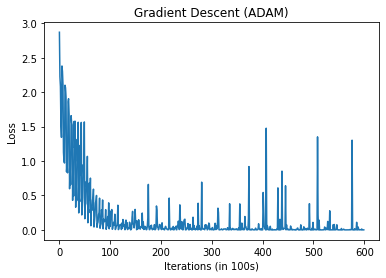

In [ ]:
plotGD(losses, model='Baseline NN')
plotAcc(validation_accs, model='Baseline NN')
